# CFA for ETS Scale

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ncx2
import scaledev
import seaborn as sns
import matplotlib.pyplot as plt
from semopy import inspector, Model, Optimizer, semplot, calc_stats, report
from scaledev import preprocessor

In [2]:
data_loc = scaledev.get_data_dir()

# Show full dataframes when printing
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
np.set_printoptions(threshold=100, suppress=True)

# load raw data
df_raw = pd.read_excel(data_loc / "cfa.xlsx")
df_raw.head()

,Inclusion1,Inclusion2,Inclusion3,Inclusion4,Inclusion5,Presence1,Presence2,Presence3,Presence4,Presence5,Presence6,Embod1,Embod2,Embod3,Embod4,Embod5,Wonder1,Wonder2,Wonder3,Wonder4,Frequency,Age,Gender,Ethnicity
0,3,3,4,5,3,3,4,4,3,5,5,4,5,4,4,3,4,4,4,4,2,3,1,5
1,5,5,5,4,4,5,5,4,5,5,4,3,3,3,3,6,4,3,3,4,2,4,3,5
2,4,5,4,5,4,4,5,5,5,5,4,5,5,5,5,4,3,4,5,4,3,2,1,5
3,3,3,4,4,3,4,5,4,4,4,4,2,4,4,3,3,3,3,3,4,1,3,3,5
4,6,6,6,6,6,3,5,3,3,2,2,2,1,1,1,2,5,5,3,2,1,3,3,3


In [3]:
# Clean up the column names
df_raw = preprocessor.clean_columns(df_raw)

# Start data cleaning
df = df_raw.copy()

# scale items - to use later for filtering down the dataframe
scale_items = [c for c in df.columns if c not in ["frequency", "age", "gender", "ethnicity"]]

# Create the factor and total scores
df["inclusion_total"] = df[["inclusion1", "inclusion2", "inclusion3", "inclusion4", "inclusion5"]].sum(axis=1)
df["presence_total"] = df[["presence1", "presence2", "presence3", "presence4", "presence5", "presence6"]].sum(axis=1)
df["embod_total"] = df[["embod1", "embod2", "embod3", "embod4", "embod5"]].sum(axis=1)
df["wonder_total"] = df[["wonder1", "wonder2", "wonder3", "wonder4"]].sum(axis=1)
df["ets_total"] = df[scale_items].sum(axis=1)

df.head()

,inclusion1,inclusion2,inclusion3,inclusion4,inclusion5,presence1,presence2,presence3,presence4,presence5,presence6,embod1,embod2,embod3,embod4,embod5,wonder1,wonder2,wonder3,wonder4,frequency,age,gender,ethnicity,inclusion_total,presence_total,embod_total,wonder_total,ets_total
0,3,3,4,5,3,3,4,4,3,5,5,4,5,4,4,3,4,4,4,4,2,3,1,5,18,24,20,16,78
1,5,5,5,4,4,5,5,4,5,5,4,3,3,3,3,6,4,3,3,4,2,4,3,5,23,28,18,14,83
2,4,5,4,5,4,4,5,5,5,5,4,5,5,5,5,4,3,4,5,4,3,2,1,5,22,28,24,16,90
3,3,3,4,4,3,4,5,4,4,4,4,2,4,4,3,3,3,3,3,4,1,3,3,5,17,25,16,13,71
4,6,6,6,6,6,3,5,3,3,2,2,2,1,1,1,2,5,5,3,2,1,3,3,3,30,18,7,15,70


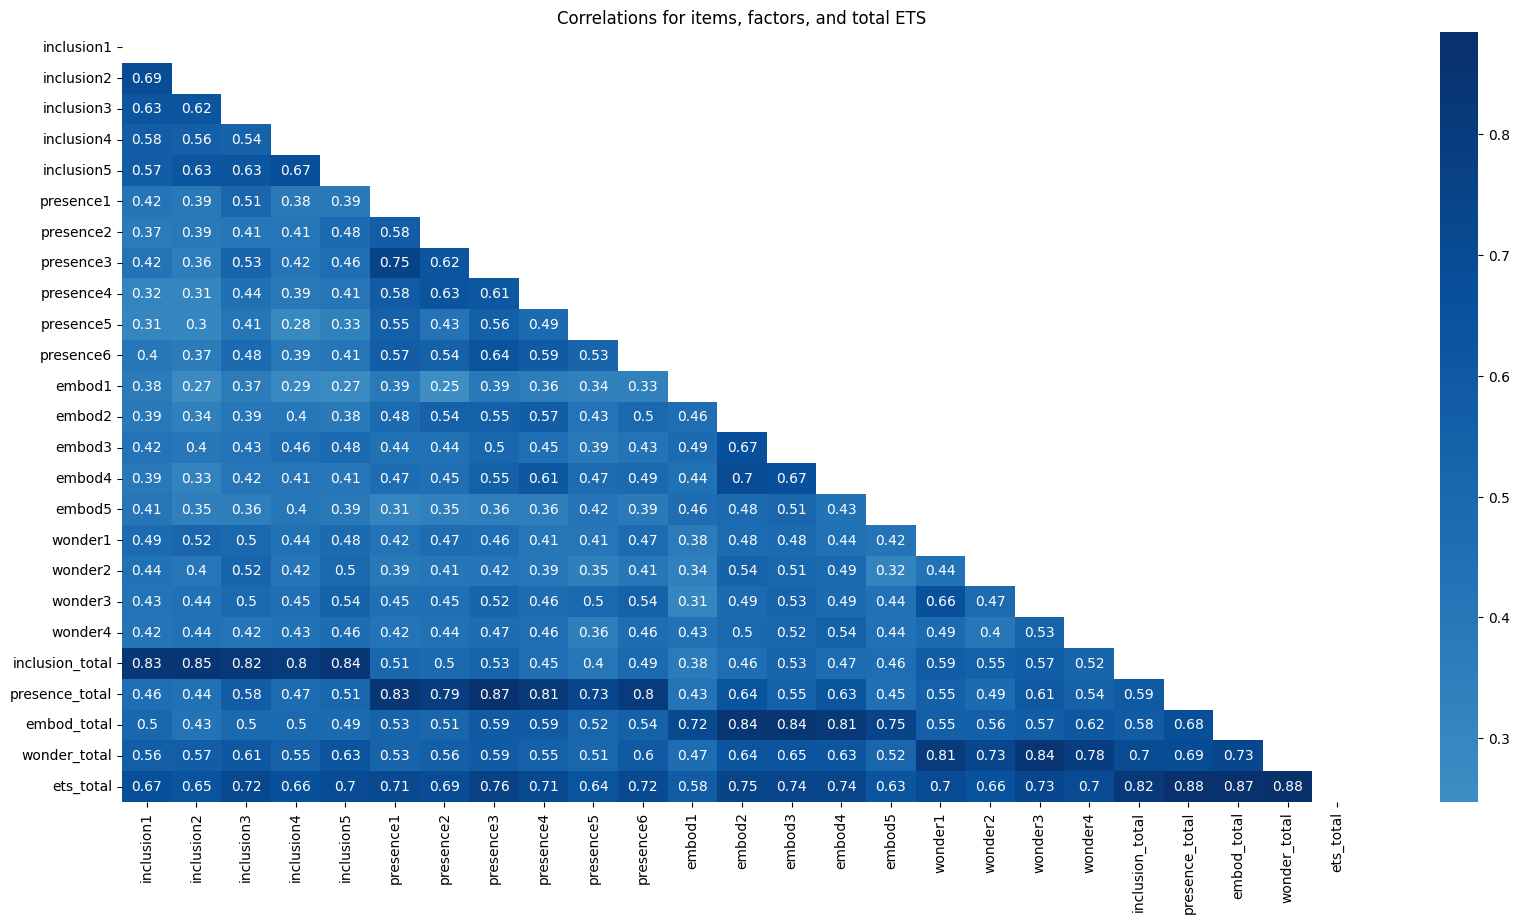

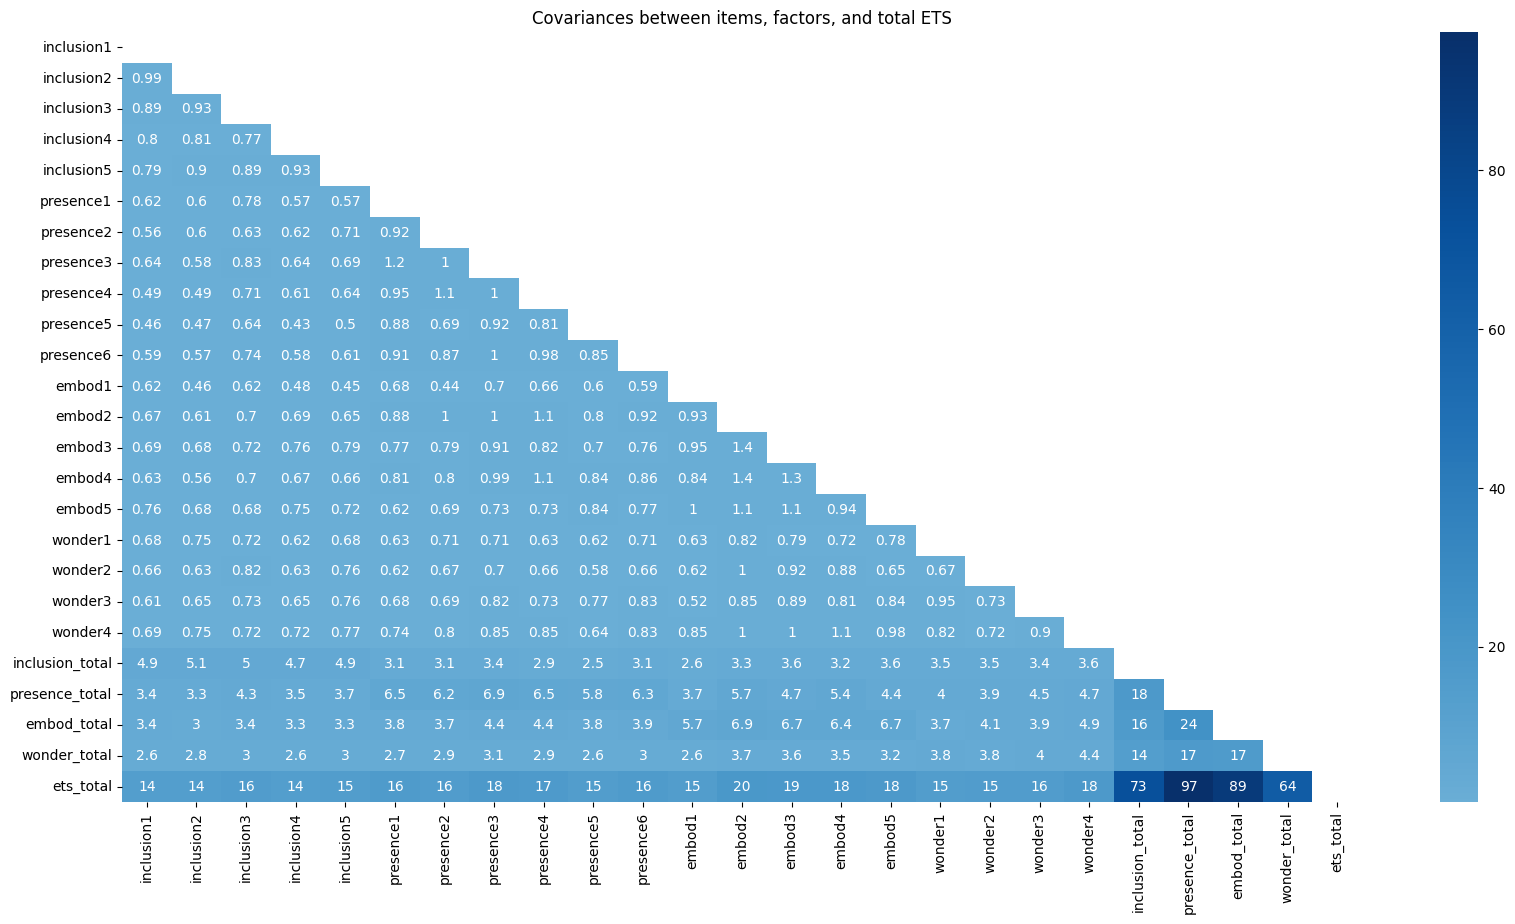

In [4]:
fig, ax = plt.subplots(figsize=(20, 10))
numeric_cols = [c for c in df.columns if c not in ["frequency", "age", "gender", "ethnicity"]]
corr_df = df[numeric_cols].corr()
mask = np.triu(np.ones_like(corr_df, dtype=bool))
sns.heatmap(corr_df, annot=True, cmap="Blues", ax=ax, center=0, mask=mask)
ax.set_title("Correlations for items, factors, and total ETS")
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(df[numeric_cols].cov(), annot=True, cmap="Blues", ax=ax, center=0, mask=mask)
ax.set_title("Covariances between items, factors, and total ETS");

In [5]:
df_model = df[scale_items]
model_spec = """
    # Latent variables (factors) - with identification constraints
    inclusion =~ 1*inclusion1 + inclusion2 + inclusion3 + inclusion4 + inclusion5
    presence =~ 1*presence1 + presence2 + presence3 + presence4 + presence5 + presence6
    embod =~ 1*embod1 + embod2 + embod3 + embod4 + embod5
    wonder =~ 1*wonder1 + wonder2 + wonder3 + wonder4
    
    # Higher-order factor (ETS)
    ETS =~ inclusion + presence + embod + wonder

    # Factor correlations (allow them to correlate since we used oblique rotations)
    inclusion ~~ presence
    inclusion ~~ embod
    inclusion ~~ wonder
    presence ~~ embod
    presence ~~ wonder
    embod ~~ wonder
    
    # Fix variance of ETS to 1 for identification
    ETS ~~ 1*ETS
"""


model = Model(model_spec)
model.fit(df_model, solver="L-BFGS-B")


SolverResult(fun=np.float64(1.7441866350103088), success=True, n_it=8, x=array([0.96945572, 0.95260717, 0.87615373, 0.93898157, 0.83784747,
       0.98999301, 0.88352757, 0.75335294, 0.85023246, 1.02036313,
       0.97920693, 0.9516968 , 0.88237224, 0.83553078, 0.91033219,
       0.96254504, 0.43564905, 0.49275054, 0.48565491, 0.17304818,
       0.22033741, 0.28893569, 0.07857517, 0.48861182, 0.40191463,
       1.10903924, 0.70382117, 1.14445308, 1.21300033, 0.97346308,
       0.86489546, 0.8955014 , 1.43145916, 0.49802513, 0.54659388,
       0.56350931, 0.63491864, 0.48360237, 0.53801998, 0.76295734,
       0.43538328, 0.74960051, 0.92258527, 0.70747519, 0.82262405,
       0.65901745, 0.99857088, 0.63243542, 1.09773039]), message='CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH', name_method='L-BFGS-B', name_obj='MLW')

In [6]:
# Calculate fit statistics
fit_stats = calc_stats(model)

# Print the fit statistics
fit_stats


,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,161,190,624.41882,0.00000,4471.70860,0.89177,0.86036,0.83521,0.86036,0.87227,0.08979,94.51163,284.65774,1.74419


In [7]:
report(model=model, name="ETS Scale", std_est=True)

In [8]:
stats = calc_stats(model)
rmsea = stats['RMSEA']
dof = stats['DoF'] # Degrees of freedom
n = model.n_samples  # Sample size

# Calculate the non-centrality parameter (lambda)
lambda_hat = n * dof * rmsea**2

# Find the lower and upper bounds of the non-centrality parameter
# using the non-central chi-square distribution
alpha = 0.1  # For a 90% CI
lower_lambda = ncx2.ppf(alpha / 2, dof, lambda_hat)
upper_lambda = ncx2.ppf(1 - alpha / 2, dof, lambda_hat)

# Convert the non-centrality parameters back to RMSEA
lower_rmsea = np.sqrt(lower_lambda / (n * dof))
upper_rmsea = np.sqrt(upper_lambda / (n * dof))
 # if lower_lambda is 0, lower_rmsea should also be 0
if lower_lambda == 0:
     lower_rmsea = 0

# Corrected printing: Extract the numerical values using .item()
print(f"RMSEA 90% CI (Manual): ({lower_rmsea.item():.3f}, {upper_rmsea.item():.3f})")


RMSEA 90% CI (Manual): (0.098, 0.111)


In [9]:
opt = Optimizer(model)
objective_function_value = opt.optimize()

inspector.inspect(opt, std_est=True)

,lval,op,rval,Estimate,Est. Std,Std. Err,z-value,p-value
0,inclusion,~,ETS,1.00000,1.00000,-,-,-
1,presence,~,ETS,0.44257,0.43176,0.06566,6.74060,0.00000
2,embod,~,ETS,0.15781,0.19131,0.06430,2.45420,0.01412
3,wonder,~,ETS,0.40530,0.44970,0.06355,6.37820,0.00000
4,inclusion1,~,inclusion,1.00000,0.80898,-,-,-
5,inclusion2,~,inclusion,1.00728,0.80391,0.05927,16.99411,0.00000
6,inclusion3,~,inclusion,0.99256,0.79718,0.05906,16.80521,0.00000
7,inclusion4,~,inclusion,0.91296,0.75498,0.05836,15.64438,0.00000
8,inclusion5,~,inclusion,0.98055,0.81544,0.05661,17.32022,0.00000
9,presence1,~,presence,1.00000,0.80998,-,-,-


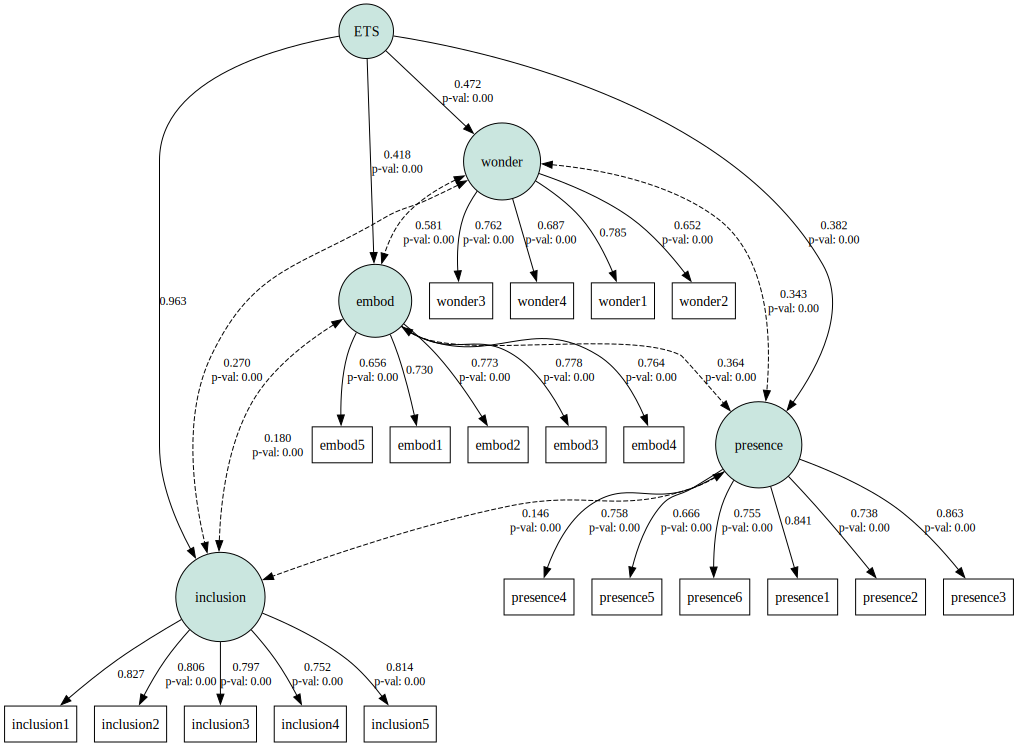

In [10]:
# path diagram
semplot(mod=model, plot_covs=True, std_ests=True, filename="cfa_model_plot.png")

In [11]:
# Check for multicollinearity
correlation_matrix = df_model.corr()
print(correlation_matrix)

#Check for zero or near-zero variance
print(df_model.var())

            inclusion1  inclusion2  inclusion3  inclusion4  inclusion5  \
inclusion1     1.00000     0.69113     0.62602     0.57714     0.57072   
inclusion2     0.69113     1.00000     0.62183     0.55772     0.62799   
inclusion3     0.62602     0.62183     1.00000     0.53540     0.62658   
inclusion4     0.57714     0.55772     0.53540     1.00000     0.67204   
inclusion5     0.57072     0.62799     0.62658     0.67204     1.00000   
presence1      0.41923     0.39023     0.51412     0.38239     0.39087   
presence2      0.37481     0.38756     0.40854     0.41292     0.47684   
presence3      0.42319     0.36339     0.52553     0.41987     0.45648   
presence4      0.31653     0.30585     0.44462     0.39351     0.41415   
presence5      0.30718     0.30140     0.41262     0.28400     0.33412   
presence6      0.39970     0.37049     0.48334     0.38882     0.41052   
embod1         0.37660     0.26907     0.36798     0.29088     0.27436   
embod2         0.39018     0.34069    

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Add a constant term (required for VIF calculation)
X = add_constant(df_model)

# Calculate VIFs
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

       feature      VIF
0        const 24.68164
1   inclusion1  2.48192
2   inclusion2  2.55387
3   inclusion3  2.53955
4   inclusion4  2.14624
5   inclusion5  2.74938
6    presence1  2.76619
7    presence2  2.34934
8    presence3  3.24570
9    presence4  2.52429
10   presence5  1.85424
11   presence6  2.17041
12      embod1  1.68138
13      embod2  2.81670
14      embod3  2.57437
15      embod4  2.82952
16      embod5  1.74306
17     wonder1  2.20459
18     wonder2  1.82884
19     wonder3  2.50746
20     wonder4  1.89548
